# In this notebook a simple Q learner will be trained and evaluated. The Q learner recommends when to buy or sell shares of one particular stock, and in which quantity (in fact it determines the desired fraction of shares in the total portfolio value). One initial attempt was made to train the Q-learner with multiple processes, but it was unsuccessful.

In [1]:
# Basic imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import scipy.optimize as spo
import sys
from time import time
from sklearn.metrics import r2_score, median_absolute_error
from multiprocessing import Pool

%matplotlib inline

%pylab inline
pylab.rcParams['figure.figsize'] = (20.0, 10.0)

%load_ext autoreload
%autoreload 2

sys.path.append('../../')

import recommender.simulator as sim
from utils.analysis import value_eval
from recommender.agent import Agent
from functools import partial

Populating the interactive namespace from numpy and matplotlib


In [2]:
NUM_THREADS = 1
LOOKBACK = 252*2 + 28
STARTING_DAYS_AHEAD = 20
POSSIBLE_FRACTIONS = [0.0, 1.0]

# Get the data
SYMBOL = 'SPY'
total_data_train_df = pd.read_pickle('../../data/data_train_val_df.pkl').stack(level='feature')
data_train_df = total_data_train_df[SYMBOL].unstack()
total_data_test_df = pd.read_pickle('../../data/data_test_df.pkl').stack(level='feature')
data_test_df = total_data_test_df[SYMBOL].unstack()
if LOOKBACK == -1:
    total_data_in_df = total_data_train_df
    data_in_df = data_train_df
else:
    data_in_df = data_train_df.iloc[-LOOKBACK:]
    total_data_in_df = total_data_train_df.loc[data_in_df.index[0]:]

# Create many agents
index = np.arange(NUM_THREADS).tolist()
env, num_states, num_actions = sim.initialize_env(total_data_in_df, 
                                                  SYMBOL, 
                                                  starting_days_ahead=STARTING_DAYS_AHEAD,
                                                  possible_fractions=POSSIBLE_FRACTIONS,
                                                  n_levels=10)
agents = [Agent(num_states=num_states, 
                num_actions=num_actions, 
                random_actions_rate=0.98, 
                random_actions_decrease=0.9999,
                dyna_iterations=0,
                name='Agent_{}'.format(i)) for i in index]

In [3]:
def show_results(results_list, data_in_df, graph=False):
    for values in results_list:
        total_value = values.sum(axis=1)
        print('Sharpe ratio: {}\nCum. Ret.: {}\nAVG_DRET: {}\nSTD_DRET: {}\nFinal value: {}'.format(*value_eval(pd.DataFrame(total_value))))
        print('-'*100)
        initial_date = total_value.index[0]
        compare_results = data_in_df.loc[initial_date:, 'Close'].copy()
        compare_results.name = SYMBOL
        compare_results_df = pd.DataFrame(compare_results)
        compare_results_df['portfolio'] = total_value
        std_comp_df = compare_results_df / compare_results_df.iloc[0]
        if graph:
            plt.figure()
            std_comp_df.plot()

## Let's show the symbols data, to see how good the recommender has to be.

In [4]:
print('Sharpe ratio: {}\nCum. Ret.: {}\nAVG_DRET: {}\nSTD_DRET: {}\nFinal value: {}'.format(*value_eval(pd.DataFrame(data_in_df['Close'].iloc[STARTING_DAYS_AHEAD:]))))

Sharpe ratio: 1.601691549431671
Cum. Ret.: 0.4244923418116293
AVG_DRET: 0.0007179294312480581
STD_DRET: 0.00711546265440581
Final value: 205.54


In [5]:
# Simulate (with new envs, each time)
n_epochs = 4

for i in range(n_epochs):
    tic = time()
    env.reset(STARTING_DAYS_AHEAD)
    results_list = sim.simulate_period(total_data_in_df, 
                                       SYMBOL,
                                       agents[0],
                                       starting_days_ahead=STARTING_DAYS_AHEAD,
                                       possible_fractions=POSSIBLE_FRACTIONS,
                                       verbose=False,
                                       other_env=env)
    toc = time()
    print('Epoch: {}'.format(i))
    print('Elapsed time: {} seconds.'.format((toc-tic)))
    print('Random Actions Rate: {}'.format(agents[0].random_actions_rate))
    show_results([results_list], data_in_df)

Starting simulation for agent: Agent_0. 512 days of simulation to go.
Date 2014-12-31 00:00:00 (simulating until 2014-12-31 00:00:00).  Time: 0.41817784309387207s.  Value: 12168.139999999992.Epoch: 0
Elapsed time: 20.483190059661865 seconds.
Random Actions Rate: 0.931177595147864
Sharpe ratio: 1.2889223684915965
Cum. Ret.: 0.21681399999999917
AVG_DRET: 0.0003967573808976275
STD_DRET: 0.004886506990702265
Final value: 12168.139999999992
----------------------------------------------------------------------------------------------------
Starting simulation for agent: Agent_0. 512 days of simulation to go.
Date 2014-12-31 00:00:00 (simulating until 2014-12-31 00:00:00).  Time: 0.3629131317138672s.  Value: 12374.689999999999.Epoch: 1
Elapsed time: 18.908121347427368 seconds.
Random Actions Rate: 0.8847874629646538
Sharpe ratio: 1.3672870229363716
Cum. Ret.: 0.23746899999999993
AVG_DRET: 0.0004303316681001886
STD_DRET: 0.00499624682734228
Final value: 12374.689999999999
--------------------

Starting simulation for agent: Agent_0. 512 days of simulation to go.
Date 2014-12-31 00:00:00 (simulating until 2014-12-31 00:00:00).  Time: 0.3828146457672119s.  Value: 13971.230000000021.Sharpe ratio: 2.031446601959524
Cum. Ret.: 0.3971230000000021
AVG_DRET: 0.0006695972758187293
STD_DRET: 0.005232491571298451
Final value: 13971.230000000021
----------------------------------------------------------------------------------------------------


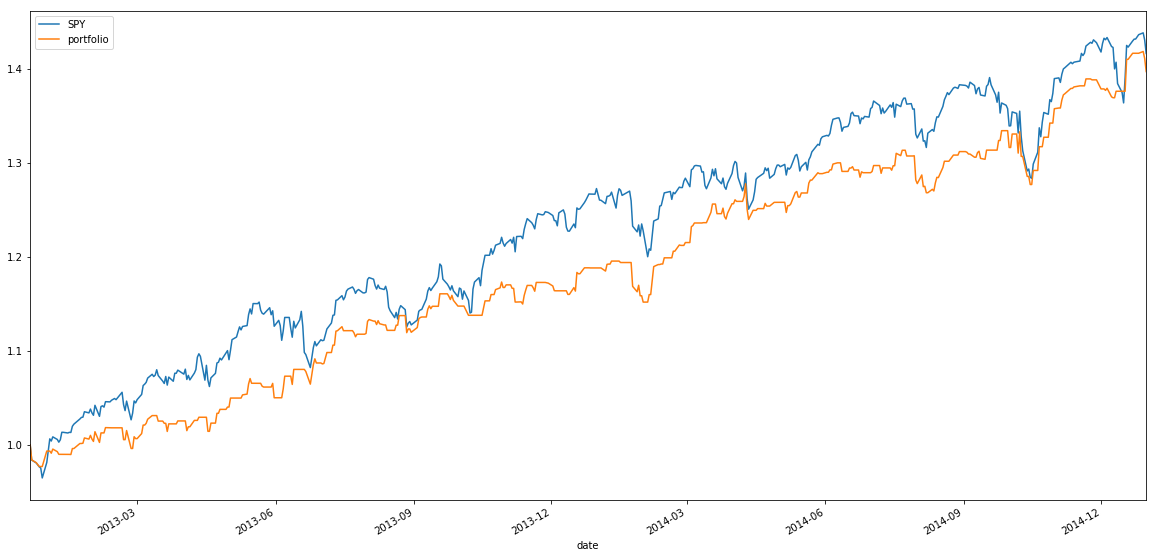

In [6]:
env.reset(STARTING_DAYS_AHEAD)
results_list = sim.simulate_period(total_data_in_df, 
                                   SYMBOL, agents[0], 
                                   learn=False, 
                                   starting_days_ahead=STARTING_DAYS_AHEAD,
                                   possible_fractions=POSSIBLE_FRACTIONS,
                                   other_env=env)
show_results([results_list], data_in_df, graph=True)

## Let's run the trained agent, with the test set

### First a non-learning test: this scenario would be worse than what is possible (in fact, the q-learner can learn from past samples in the test set without compromising the causality).

Starting simulation for agent: Agent_0. 484 days of simulation to go.
Date 2016-12-28 00:00:00 (simulating until 2016-12-30 00:00:00).  Time: 0.36539530754089355s.  Value: 11616.270000000006.Epoch: 3
Elapsed time: 19.452654361724854 seconds.
Random Actions Rate: 0.7988253618565566
Sharpe ratio: 0.8228017709095453
Cum. Ret.: 0.16162700000000063
AVG_DRET: 0.00033129841707842567
STD_DRET: 0.006391818192393487
Final value: 11616.270000000006
----------------------------------------------------------------------------------------------------


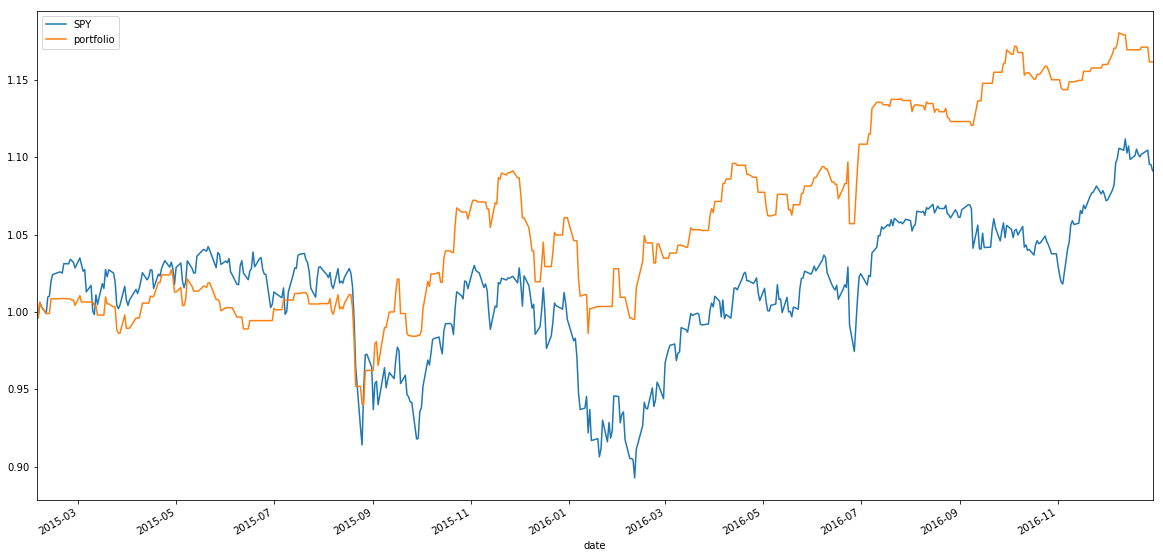

In [7]:
TEST_DAYS_AHEAD = 20

env.set_test_data(total_data_test_df, TEST_DAYS_AHEAD)
tic = time()
results_list = sim.simulate_period(total_data_test_df, 
                                    SYMBOL,
                                    agents[0],
                                    learn=False,
                                    starting_days_ahead=TEST_DAYS_AHEAD,
                                    possible_fractions=POSSIBLE_FRACTIONS,
                                    verbose=False,
                                    other_env=env)
toc = time()
print('Epoch: {}'.format(i))
print('Elapsed time: {} seconds.'.format((toc-tic)))
print('Random Actions Rate: {}'.format(agents[0].random_actions_rate))
show_results([results_list], data_test_df, graph=True)

### And now a "realistic" test, in which the learner continues to learn from past samples in the test set (it even makes some random moves, though very few).

Starting simulation for agent: Agent_0. 484 days of simulation to go.
Date 2016-12-28 00:00:00 (simulating until 2016-12-30 00:00:00).  Time: 0.26916980743408203s.  Value: 10254.53.Epoch: 3..
Elapsed time: 15.724592685699463 seconds.
Random Actions Rate: 0.7611572220667355
Sharpe ratio: 0.17618139275375405
Cum. Ret.: 0.02545300000000017
AVG_DRET: 7.491384467118925e-05
STD_DRET: 0.006749977383799452
Final value: 10254.53
----------------------------------------------------------------------------------------------------


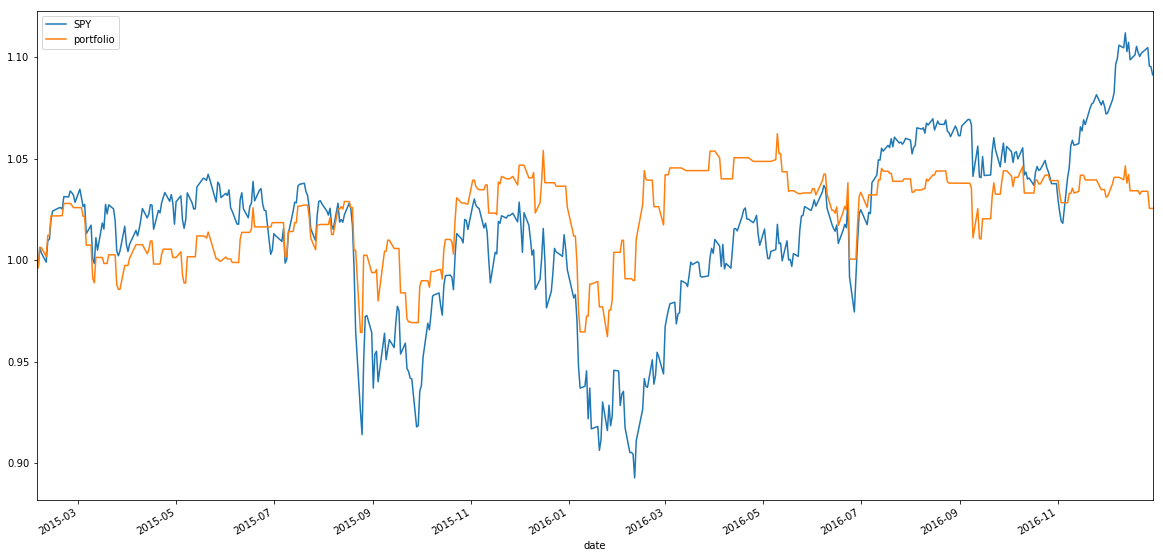

In [8]:
env.set_test_data(total_data_test_df, TEST_DAYS_AHEAD)
tic = time()
results_list = sim.simulate_period(total_data_test_df, 
                                    SYMBOL,
                                    agents[0],
                                    learn=True,
                                    starting_days_ahead=TEST_DAYS_AHEAD,
                                    possible_fractions=POSSIBLE_FRACTIONS,
                                    verbose=False,
                                    other_env=env)
toc = time()
print('Epoch: {}'.format(i))
print('Elapsed time: {} seconds.'.format((toc-tic)))
print('Random Actions Rate: {}'.format(agents[0].random_actions_rate))
show_results([results_list], data_test_df, graph=True)

In [9]:
print('Sharpe ratio: {}\nCum. Ret.: {}\nAVG_DRET: {}\nSTD_DRET: {}\nFinal value: {}'.format(*value_eval(pd.DataFrame(data_test_df['Close'].iloc[TEST_DAYS_AHEAD:]))))

Sharpe ratio: 0.44271542660031676
Cum. Ret.: 0.1070225832012679
AVG_DRET: 0.00025103195406808796
STD_DRET: 0.009001287260690292
Final value: 223.53


In [10]:
import pickle
with open('../../data/simple_q_learner_fast_learner_10000_states.pkl', 'wb') as best_agent:
    pickle.dump(agents[0], best_agent)